## Dog Breed Classification

In this we will use Transfer Learning by Inception model with weights pre-trained on Imagenet.

### Load Dataset Files

Run the below code to mount the google drive and access the files in drive

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
project_path = "/content/drive/My Drive/AIML/Lab/Visualization/Internal/"

In [4]:
!ls -ltr /content/drive/My\ Drive/AIML/Lab/Visualization/Internal/

total 353232
-rw------- 1 root root 361279070 Dec  2 09:01 train.zip
-rw------- 1 root root    218954 Dec  2 09:01 labels.csv.zip
-rw------- 1 root root     10074 Dec  2 09:11 FashionMNIST_Tensorboard_Questions-1.ipynb
-rw------- 1 root root    199741 Dec  2 10:34 TransferLearning_Dog_Breed_Classification-Questions-1.ipynb


Run the below code to extract all the images in the train.zip and labels.csv.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip', 'r') as z:
  z.extractall()

In [0]:
# from zipfile import ZipFile
# with ZipFile(project_path+'test.zip', 'r') as z:
#   z.extractall()

In [0]:
# from zipfile import ZipFile
# with ZipFile(project_path+'sample_submission.csv.zip', 'r') as z:
#   z.extractall()

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'labels.csv.zip', 'r') as z:
  z.extractall()

### Read labels.csv file using pandas

In [9]:
!ls

drive  labels.csv  sample_data	test.jpg  train


In [0]:
import pandas as pd

df = pd.read_csv('labels.csv')

In [11]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Print the count of each category of Dogs given in the dataset

You can use value_counts() to get the count of each category

In [12]:
df['breed'].value_counts()

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
pomeranian                        111
great_pyrenees                    111
basenji                           110
samoyed                           109
airedale                          107
tibetan_terrier                   107
leonberg                          106
cairn                             106
beagle                            105
japanese_spaniel                  105
australian_terrier                102
miniature_pinscher                102
blenheim_spaniel                  102
irish_wolfhound                   101
saluki                             99
lakeland_terrier                   99
papillon                           96
whippet                            95
siberian_husky                     95
norwegian_elkhound                 95
pug         

### Get one-hot encodings of labels

In [0]:
import tensorflow as tf
from sklearn import preprocessing

In [0]:
le = preprocessing.LabelEncoder()
tmp = le.fit_transform(df['breed'])
one_hot_labels = tf.keras.utils.to_categorical(tmp, num_classes=120)

### Form feature set using the images in `train` folder and their corresponding labels from `labels.csv`

Run the below given code to form the feature set. Here, we are resizing each image to 150x150x3 as the Inception model we will be using in the further steps for transfer learning needs input image in this dimension.

In [0]:
img_rows=150
img_cols=150
num_channel=3
labels = df

In [16]:
df.values

array([['000bec180eb18c7604dcecc8fe0dba07', 'boston_bull'],
       ['001513dfcb2ffafc82cccf4d8bbaba97', 'dingo'],
       ['001cdf01b096e06d78e9e5112d419397', 'pekinese'],
       ...,
       ['ffe2ca6c940cddfee68fa3cc6c63213f', 'airedale'],
       ['ffe5f6d8e2bff356e9482a80a6e29aac', 'miniature_pinscher'],
       ['fff43b07992508bc822f33d8ffd902ae', 'chesapeake_bay_retriever']],
      dtype=object)

In [17]:
from tqdm import tqdm
import cv2
x_feature = []
y_feature = []
"""
i = 0 # initialisation
for f, img in tqdm(labels.values): # f for format ,jpg
    train_img = cv2.imread('./train/{}.jpg'.format(f),1)
    label = one_hot_labels[i]
    train_img_resize = cv2.resize(train_img, (img_rows, img_cols)) 
    x_feature.append(train_img_resize)
    y_feature.append(label)
    i += 1
"""

from PIL import ImageOps, Image

i = 0 # initialisation
for f, img in tqdm(labels.values): # f for format ,jpg
    train_img = Image.open('./train/{}.jpg'.format(f))
    old_size = train_img.size
    ratio = float(150) / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    train_img = train_img.resize(new_size, Image.ANTIALIAS)
    new_img = Image.new("RGB", (150, 150))
    new_img.paste(train_img, ((150 - new_size[0])//2, (150 - new_size[1])//2))
    new_img.save('test.jpg', "JPEG", quality=80, optimize=True, progressive=True)
    label = one_hot_labels[i]
    train_img_resize = cv2.imread('test.jpg', 1) 
    x_feature.append(train_img_resize)
    y_feature.append(label)
    i += 1

100%|██████████| 10222/10222 [01:54<00:00, 89.00it/s]


In [18]:
import numpy as np

x_train_data = np.array(x_feature, np.float32) / 255.   # /= 255 for normolisation
print (x_train_data.shape)
# x_train_data = np.expand_dims(x_train_data, axis = 3) # for keras to given input to Conv2D layer
# print (x_train_data.shape)


(10222, 150, 150, 3)


In [19]:
y_train_data = np.array(y_feature)

y_train_data.shape

(10222, 120)

We have the normalized feature set ready in `x_train_data` and `y_train_data` varaibles.

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train_data, y_train_data, test_size=0.30, random_state=1)

### Import the IncpetionResNetV2 model which we use for Transfer Learning.

Run the below code to import the inception model.

In [21]:
from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

Using TensorFlow backend.


In [0]:
#get the length of the train and validation data
ntrain = len(x_train)
nval = len(x_val)

#We will use a batch size of 32. 
batch_size = 32  

### Build the network using above inception model and add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
x = conv_base.output

In [0]:
import keras as keras

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
y = keras.layers.Dense(120, activation='softmax')(x)

### Now, freeze the layers in inception model as we dont want to train those layers.

Run the below code to freeze the inception model layers.

In [0]:
conv_base.trainable = False

### Compile the model using Adam optimizer with `categorical_crossentropy` loss function

In [0]:
model = keras.models.Model(inputs=conv_base.input, outputs=y)
model.compile(keras.optimizers.Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Data Augmentation

Run the below code to inilialize the ImageDataGenerators for train and validation data separately.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size=5, seed=10)
val_generator = val_datagen.flow(x_val, y_val, shuffle=False, batch_size=5, seed=10)

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 2 epochs

In [32]:
model.fit_generator(train_generator, steps_per_epoch=100, validation_data=val_generator, validation_steps=32, epochs=30, verbose=2)

Epoch 1/30
 - 47s - loss: 4.1467 - acc: 0.0900 - val_loss: 3.9439 - val_acc: 0.1188
Epoch 2/30
 - 47s - loss: 3.9855 - acc: 0.0980 - val_loss: 3.7442 - val_acc: 0.1375
Epoch 3/30
 - 47s - loss: 3.9763 - acc: 0.1300 - val_loss: 3.7572 - val_acc: 0.1250
Epoch 4/30
 - 47s - loss: 3.8335 - acc: 0.1240 - val_loss: 3.6264 - val_acc: 0.1375
Epoch 5/30
 - 47s - loss: 3.8136 - acc: 0.1080 - val_loss: 3.4836 - val_acc: 0.1688
Epoch 6/30
 - 47s - loss: 3.7457 - acc: 0.1240 - val_loss: 3.3359 - val_acc: 0.1750
Epoch 7/30
 - 47s - loss: 3.6212 - acc: 0.1520 - val_loss: 3.4727 - val_acc: 0.1875
Epoch 8/30
 - 47s - loss: 3.5195 - acc: 0.1880 - val_loss: 3.3451 - val_acc: 0.1813
Epoch 9/30
 - 48s - loss: 3.4768 - acc: 0.1680 - val_loss: 3.3742 - val_acc: 0.1911
Epoch 10/30
 - 48s - loss: 3.4226 - acc: 0.1880 - val_loss: 3.2556 - val_acc: 0.1813
Epoch 11/30
 - 48s - loss: 3.3394 - acc: 0.1900 - val_loss: 3.0602 - val_acc: 0.1813
Epoch 12/30
 - 48s - loss: 3.3105 - acc: 0.2020 - val_loss: 3.3219 - val_a

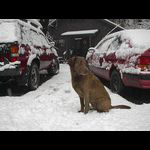

In [31]:
img = tf.keras.preprocessing.image.load_img('test.jpg')
img